# Notes 2 - Predictors of recorded DS live births

- Train from 2016 and ignore no_congen


## Preparation


In [1]:
import joblib, optuna, os, shap
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from lightgbm import early_stopping, log_evaluation
from scipy.spatial.distance import squareform
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    brier_score_loss,
    log_loss,
)
from sklearn.model_selection import train_test_split

import repl_utils, stats_utils, data_utils, ml_utils, plot_utils
from variables import Variables as vars

pd.options.mode.copy_on_write = True

plt.style.use("../../notebook.mplstyle")

os.makedirs("./output", exist_ok=True)

RANDOM_SEED = 47
np.random.seed(RANDOM_SEED)
rng = np.random.default_rng(RANDOM_SEED)

N_CORES = joblib.cpu_count(only_physical_cores=True)

START_TIME = datetime.now()

OUTPUT_DIR = f"output/0006-predictors-4/{START_TIME:%Y%m%d-%H%M%S}"

os.makedirs(OUTPUT_DIR, exist_ok=True)

repl_utils.print_environment_info()

print(f"\n--------------------\nOutput directory: {OUTPUT_DIR}\n--------------------\n")

-------------------- Environment Information --------------------
date: 2025-12-25T17:16:13.532011
platform: Windows-11-10.0.26220-SP0
platform_version: 10.0.26220
cpu: Intel64 Family 6 Model 197 Stepping 2, GenuineIntel
cores: 16
physical_cores: 16
ram: 95 GB
ram_available: 65 GB
cuda: False
cuda_device_count: 0
cuda_device_0: False
python: 3.13.11 | packaged by conda-forge | (main, Dec  6 2025, 11:10:00) [MSC v.1944 64 bit (AMD64)]
numpy: 2.3.5
pandas: 2.3.3
scipy: 1.16.3
sklearn: 1.8.0
lightgbm: 4.6.0
pytorch: 2.9.1
pymc: 5.27.0
pytensor: 2.36.1
arviz: 0.23.0

--------------------
Output directory: output/0006-predictors-4/20251225-171613
--------------------



### Options


In [2]:
START_YEAR = 2016
END_YEAR = 2024
# LightGBM threads
NUM_THREADS = N_CORES - 2
# Splitting data for training, validation and calibration
TRAINING_SPLIT = 0.5
VALIDATION_SPLIT = 0.25
CALIBRATION_SPLIT = 1 - TRAINING_SPLIT - VALIDATION_SPLIT
#
NUM_BOOST_ROUND = 10000
EARLY_STOPPING_ROUNDS = 20
# True to search for hyperparameters
SELECT_HYPERPARAMETERS = True
#
OPTIMIZE_TRIALS = 50

SAVE_PLOTS = True

### Load data


In [3]:
df = data_utils.load_predictors_data(from_year=START_YEAR, to_year=END_YEAR, include_unknown=False)

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

### Define initial feature set


In [4]:
numeric = [
    vars.YEAR,
    vars.DBWT,
    vars.PWGT_R,
    vars.WTGAIN,
    vars.BMI,
    vars.MAGE_C,
    vars.FAGECOMB,
]

categorical = [
    vars.DOB_MM,
    vars.DOB_WK,
    "dob_tt_pm",
    vars.BFACIL3,
    vars.SEX,
    vars.PRECARE,
    vars.GESTREC10,
    vars.RF_PDIAB,
    vars.RF_GDIAB,
    vars.RF_PHYPE,
    vars.RF_GHYPE,
    vars.RF_EHYPE,
    vars.RF_PPTERM,
    vars.RF_INFTR,
    vars.RF_FEDRG,
    vars.RF_ARTEC,
    # vars.NO_RISKS,
    vars.LD_INDL,
    vars.LD_AUGM,
    vars.ME_PRES,
    vars.DMETH_REC,
    vars.APGAR5,
    vars.APGAR10,
    vars.AB_AVEN1,
    vars.AB_AVEN6,
    vars.AB_NICU,
    vars.AB_SURF,
    vars.AB_ANTI,
    vars.AB_SEIZ,
    # vars.NO_ABNORM,
    vars.CA_ANEN,
    vars.CA_MNSB,
    vars.CA_CCHD,
    vars.CA_CDH,
    vars.CA_OMPH,
    vars.CA_GAST,
    vars.CA_LIMB,
    vars.CA_CLEFT,
    vars.CA_CLPAL,
    vars.CA_HYPO,
    vars.CA_DISOR,
    # vars.NO_CONGEN,
    vars.MEDUC,
    vars.MRACEHISP,
    vars.FEDUC,
    vars.FRACEHISP,
    vars.PAY_REC,
    vars.WIC,
]

features = categorical + numeric

X = df[features]
y = df["ca_down_c_p_n"]

X[categorical] = X[categorical].astype("category")

In [5]:
y

0           0
1           0
2           0
3           0
4           0
           ..
33527699    0
33527700    0
33527701    0
33527702    0
33527703    0
Name: ca_down_c_p_n, Length: 33527704, dtype: uint8

### Split training, validation and calibration data


In [6]:
# use half the data for the training set
X_train, X_tmp, y_train, y_tmp = train_test_split(
    X, y, test_size=TRAINING_SPLIT, stratify=y, random_state=RANDOM_SEED
)

# use a quarter of the data for training validation and a quarter for calibration
X_valid, X_cal, y_valid, y_cal = train_test_split(
    X_tmp,
    y_tmp,
    test_size=(VALIDATION_SPLIT / TRAINING_SPLIT),
    stratify=y_tmp,
    random_state=RANDOM_SEED,
)

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

In [7]:
neg_count_train = y_train[y_train == 0].count()
pos_count_train = y_train[y_train == 1].count()
# scale_pos_weight = neg_count_train / pos_count_train

neg_count_valid = y_valid[y_valid == 0].count()
pos_count_valid = y_valid[y_valid == 1].count()

neg_count_cal = y_cal[y_cal == 0].count()
pos_count_cal = y_cal[y_cal == 1].count()

print(
    f"Training set: {neg_count_train} negatives, {pos_count_train} positives, probability positive {pos_count_train / neg_count_train:.8f}"
)
print(
    f"Validation set: {neg_count_valid} negatives, {pos_count_valid} positives, probability positive {pos_count_valid / neg_count_valid:.8f}"
)
print(
    f"Calibration set: {neg_count_cal} negatives, {pos_count_cal} positives, probability positive {pos_count_cal / neg_count_cal:.8f}"
)

Training set: 16754948 negatives, 8904 positives, probability positive 0.00053143
Validation set: 8377474 negatives, 4452 positives, probability positive 0.00053143
Calibration set: 8377473 negatives, 4453 positives, probability positive 0.00053154


In [8]:
base_params = {
    "objective": "binary",
    "metric": ["average_precision", "binary_logloss"],
    "boosting_type": "gbdt",
    "max_bin": 255,  # GPU 63/127; CPU 255
    # for now, we do not scale for better interpretability of outputs
    "scale_pos_weight": 1,
    "force_col_wise": True,
    "seed": RANDOM_SEED,
    "num_threads": NUM_THREADS,
    "verbosity": 1,
}

last_best_params = {    
    "learning_rate": 0.030669458443353795,
    "num_leaves": 377,
    "min_data_in_leaf": 888,
    "min_gain_to_split": 0.29725809979979523,
    "feature_fraction": 0.8225053633083914,
    "bagging_fraction": 0.792161251586521,
    "bagging_freq": 4,
    "lambda_l1": 0.4843437977635669,
    "lambda_l2": 0.4544191696235093,
}

## Hyperparameter tuning


In [9]:
def objective(trial):
    trial_params = {
        # required to change min_data_in_leaf across trials without rebuilding the Dataset
        "feature_pre_filter": False,
        # Speed / stability
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.5, log=True),
        # Tree complexity
        "num_leaves": trial.suggest_int("num_leaves", 32, 512, log=True),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 500, 10000, log=True),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0.0, 1.0),
        # Sampling
        "feature_fraction": trial.suggest_float("feature_fraction", 0.6, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.6, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        # Regularization
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
    }

    # Merge: base_params always present; trial_params override if same key exists
    params = {**base_params, **trial_params}

    pruning_cb = optuna.integration.LightGBMPruningCallback(trial, "average_precision")

    gbm = lgb.train(
        params,
        train_data,
        num_boost_round=NUM_BOOST_ROUND,
        valid_sets=[valid_data],
        callbacks=[
            lgb.early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
            lgb.log_evaluation(period=10),
            pruning_cb,
        ],
    )

    # Best score on validation
    return gbm.best_score["valid_0"]["average_precision"]


if SELECT_HYPERPARAMETERS:
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(),
        pruner=optuna.pruners.HyperbandPruner(),
    )

    study.optimize(objective, n_trials=OPTIMIZE_TRIALS)

    print(study.best_params, study.best_value)

    best = study.best_params
else:
    best = last_best_params

# Merge (best overrides base if there are collisions)
params = {**base_params, **best}
params["feature_pre_filter"] = True  # reset to default for final training

print("Parameters for training:")
for k, v in params.items():
    print(f'  "{k}": {v}')

[I 2025-12-25 17:17:18,715] A new study created in memory with name: no-name-5baea5ee-955a-4cb1-8879-04c13883414a


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0203033	valid_0's binary_logloss: 0.00416291
[20]	valid_0's average_precision: 0.0213731	valid_0's binary_logloss: 0.00402729
[30]	valid_0's average_precision: 0.0238753	valid_0's binary_logloss: 0.00393739
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[40]	valid_0's average_precision: 0.0249893	valid_0's binary_logloss: 0.00387466
[50]	valid_0's average_precision: 0.0254521	valid_0's binary_logloss: 0.00382757
[60]	valid_0's average_precision: 0.0257792	valid_0's binary_logloss: 0.00379062
[70]	valid_0's average_precision: 0.02614

[I 2025-12-25 17:25:47,417] Trial 0 finished with value: 0.029345878562233443 and parameters: {'learning_rate': 0.011941766703301462, 'num_leaves': 78, 'min_data_in_leaf': 7710, 'min_gain_to_split': 0.9854832352344473, 'feature_fraction': 0.9860248163652694, 'bagging_fraction': 0.8830903160777253, 'bagging_freq': 9, 'lambda_l1': 8.774529124853693, 'lambda_l2': 1.874282581374826e-05}. Best is trial 0 with value: 0.029345878562233443.


Early stopping, best iteration is:
[457]	valid_0's average_precision: 0.0293459	valid_0's binary_logloss: 0.00359355
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0267435	valid_0's binary_logloss: 0.00397884
[20]	valid_0's average_precision: 0.0282423	valid_0's binary_logloss: 0.00384356
[30]	valid_0's average_precision: 0.029035	valid_0's binary_logloss: 0.00376884
[40]	valid_0's average_precision: 0.0297165	valid_0's binary_logloss: 0.00372154
[50]	valid_0's average_precision: 0.0296667	valid_0's binary_logloss: 0.00368886
[60]	valid_0's average_precision: 0.029856	valid_0's binary_logloss: 0.00366578
[

[I 2025-12-25 17:27:09,002] Trial 1 finished with value: 0.02989715933845682 and parameters: {'learning_rate': 0.022627168735732, 'num_leaves': 214, 'min_data_in_leaf': 1124, 'min_gain_to_split': 0.23390915705491488, 'feature_fraction': 0.9653972849808184, 'bagging_fraction': 0.9915215115026502, 'bagging_freq': 7, 'lambda_l1': 6.17913516026395e-08, 'lambda_l2': 0.09259798503710907}. Best is trial 1 with value: 0.02989715933845682.


Early stopping, best iteration is:
[62]	valid_0's average_precision: 0.0298972	valid_0's binary_logloss: 0.00366215
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0274268	valid_0's binary_logloss: 0.00384366
[20]	valid_0's average_precision: 0.0294234	valid_0's binary_logloss: 0.00370297
[30]	valid_0's average_precision: 0.0300862	valid_0's binary_logloss: 0.0036507
[40]	valid_0's average_precision: 0.0307752	valid_0's binary_logloss: 0.00362665
[50]	valid_0's average_precision: 0.0312908	valid_0's binary_logloss: 0.00361152
[60]	valid_0's average_precision: 0.0315471	valid_0's binary_logloss: 0.00360353
[

[I 2025-12-25 17:28:54,303] Trial 2 finished with value: 0.03181651843842994 and parameters: {'learning_rate': 0.06843705070366542, 'num_leaves': 32, 'min_data_in_leaf': 2028, 'min_gain_to_split': 0.9795673910258382, 'feature_fraction': 0.6454563351263524, 'bagging_fraction': 0.926233481638939, 'bagging_freq': 6, 'lambda_l1': 2.062616387308637e-05, 'lambda_l2': 8.810447178670792}. Best is trial 2 with value: 0.03181651843842994.


Early stopping, best iteration is:
[94]	valid_0's average_precision: 0.0318165	valid_0's binary_logloss: 0.00359163
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0109605	valid_0's binary_logloss: 0.00532251
[20]	valid_0's average_precision: 0.0127301	valid_0's binary_logloss: 0.00506161


[I 2025-12-25 17:29:13,599] Trial 3 finished with value: 0.018453906464440527 and parameters: {'learning_rate': 0.14501652496382386, 'num_leaves': 78, 'min_data_in_leaf': 1058, 'min_gain_to_split': 0.7988495063381892, 'feature_fraction': 0.6629773127128943, 'bagging_fraction': 0.7502287170429038, 'bagging_freq': 10, 'lambda_l1': 0.00020490928308826548, 'lambda_l2': 3.1361112841310843e-07}. Best is trial 2 with value: 0.03181651843842994.


Early stopping, best iteration is:
[2]	valid_0's average_precision: 0.0184539	valid_0's binary_logloss: 0.0101209
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.025394	valid_0's binary_logloss: 0.00413782
[20]	valid_0's average_precision: 0.027014	valid_0's binary_logloss: 0.00399745
[30]	valid_0's average_precision: 0.0280914	valid_0's binary_logloss: 0.0039139
[40]	valid_0's average_precision: 0.0287405	valid_0's binary_logloss: 0.00385336
[50]	valid_0's average_precision: 0.0292324	valid_0's binary_logloss: 0.00380499
[60]	valid_0's average_precision: 0.0296595	valid_0's binary_logloss: 0.00376865
[70]	

[I 2025-12-25 17:33:08,511] Trial 4 finished with value: 0.031299535745001834 and parameters: {'learning_rate': 0.0131236930378681, 'num_leaves': 41, 'min_data_in_leaf': 2009, 'min_gain_to_split': 0.1333500105872678, 'feature_fraction': 0.8445861811083574, 'bagging_fraction': 0.8917684887959088, 'bagging_freq': 4, 'lambda_l1': 1.3675837408717444e-08, 'lambda_l2': 0.005343287808310917}. Best is trial 2 with value: 0.03181651843842994.


Early stopping, best iteration is:
[252]	valid_0's average_precision: 0.0312995	valid_0's binary_logloss: 0.00360327
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:33:10,659] Trial 5 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0282639	valid_0's binary_logloss: 0.00396274
[20]	valid_0's average_precision: 0.0299191	valid_0's binary_logloss: 0.00382054
[30]	valid_0's average_precision: 0.0307932	valid_0's binary_logloss: 0.00374895
[40]	valid_0's average_precision: 0.0314901	valid_0's binary_logloss: 0.00370141
[50]	valid_0's average_precision: 0.031927	valid_0's binary_logloss: 0.00366878
[60]	valid_0's average_precision: 0.0322542	valid_0's binary_logloss: 0.00364679
[70]	valid_0's average_precision: 0.0323998	valid_0's binary_logloss: 0.0036311
[80]	valid_0's average_precision: 0.0

[I 2025-12-25 17:35:15,925] Trial 6 finished with value: 0.03290298879656746 and parameters: {'learning_rate': 0.02942871659023857, 'num_leaves': 72, 'min_data_in_leaf': 1675, 'min_gain_to_split': 0.8810843412834419, 'feature_fraction': 0.7247521155367562, 'bagging_fraction': 0.8016621734201459, 'bagging_freq': 5, 'lambda_l1': 5.021934905765539, 'lambda_l2': 0.010775510341599587}. Best is trial 6 with value: 0.03290298879656746.


Early stopping, best iteration is:
[109]	valid_0's average_precision: 0.032903	valid_0's binary_logloss: 0.00360418
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0271039	valid_0's binary_logloss: 0.0038883
[20]	valid_0's average_precision: 0.0289119	valid_0's binary_logloss: 0.00374293
[30]	valid_0's average_precision: 0.0297591	valid_0's binary_logloss: 0.00367582
[40]	valid_0's average_precision: 0.0305945	valid_0's binary_logloss: 0.00364036
[50]	valid_0's average_precision: 0.0310654	valid_0's binary_logloss: 0.00361802
[60]	valid_0's average_precision: 0.0310349	valid_0's binary_logloss: 0.00360646


[I 2025-12-25 17:36:30,793] Trial 7 finished with value: 0.03106543857393915 and parameters: {'learning_rate': 0.042311911698346194, 'num_leaves': 176, 'min_data_in_leaf': 6430, 'min_gain_to_split': 0.1385799451474261, 'feature_fraction': 0.8812952035720526, 'bagging_fraction': 0.9751544296368541, 'bagging_freq': 1, 'lambda_l1': 0.0060551520282299594, 'lambda_l2': 4.98377904290598}. Best is trial 6 with value: 0.03290298879656746.


[70]	valid_0's average_precision: 0.031059	valid_0's binary_logloss: 0.00359899
Early stopping, best iteration is:
[50]	valid_0's average_precision: 0.0310654	valid_0's binary_logloss: 0.00361802
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:36:32,888] Trial 8 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0287906	valid_0's binary_logloss: 0.00399764
[20]	valid_0's average_precision: 0.0295287	valid_0's binary_logloss: 0.00386112
[30]	valid_0's average_precision: 0.0303555	valid_0's binary_logloss: 0.00378324
[40]	valid_0's average_precision: 0.0307998	valid_0's binary_logloss: 0.00373285
[50]	valid_0's average_precision: 0.0311842	valid_0's binary_logloss: 0.00369577
[60]	valid_0's average_precision: 0.0313639	valid_0's binary_logloss: 0.00367035
[70]	valid_0's average_precision: 0.0315797	valid_0's binary_logloss: 0.00365086
[80]	valid_0's average_precision: 0

[I 2025-12-25 17:38:31,459] Trial 9 finished with value: 0.032278028594830636 and parameters: {'learning_rate': 0.022978986229535116, 'num_leaves': 49, 'min_data_in_leaf': 1667, 'min_gain_to_split': 0.5061966836112002, 'feature_fraction': 0.8804418775465939, 'bagging_fraction': 0.6178819732806246, 'bagging_freq': 6, 'lambda_l1': 0.4903438503311871, 'lambda_l2': 0.2722488573439159}. Best is trial 6 with value: 0.03290298879656746.


Early stopping, best iteration is:
[127]	valid_0's average_precision: 0.032278	valid_0's binary_logloss: 0.00360495
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:38:34,070] Trial 10 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:38:37,212] Trial 11 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:38:40,815] Trial 12 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0249462	valid_0's binary_logloss: 0.00401758
[20]	valid_0's average_precision: 0.0271291	valid_0's binary_logloss: 0.00387887
[30]	valid_0's average_precision: 0.0280728	valid_0's binary_logloss: 0.00380185
[40]	valid_0's average_precision: 0.0287676	valid_0's binary_logloss: 0.00375017
[50]	valid_0's average_precision: 0.0292531	valid_0's binary_logloss: 0.00371274
[60]	valid_0's average_precision: 0.0296075	valid_0's binary_logloss: 0.00368538
[70]	valid_0's average_precision: 0.029673	valid_0's binary_logloss: 0.0036651
[80]	valid_0's average_precision: 0.0

[I 2025-12-25 17:39:53,304] Trial 13 finished with value: 0.02967520760224329 and parameters: {'learning_rate': 0.022646153953601894, 'num_leaves': 107, 'min_data_in_leaf': 745, 'min_gain_to_split': 0.5721142746953392, 'feature_fraction': 0.8064078313973198, 'bagging_fraction': 0.7505466302164145, 'bagging_freq': 5, 'lambda_l1': 0.07661579909614383, 'lambda_l2': 0.005237923555925433}. Best is trial 6 with value: 0.03290298879656746.


Early stopping, best iteration is:
[64]	valid_0's average_precision: 0.0296752	valid_0's binary_logloss: 0.00367655
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:39:55,467] Trial 14 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:39:57,741] Trial 15 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:40:00,008] Trial 16 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:40:03,179] Trial 17 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:40:05,904] Trial 18 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:40:10,541] Trial 19 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0252193	valid_0's binary_logloss: 0.00405323
[20]	valid_0's average_precision: 0.0262999	valid_0's binary_logloss: 0.00390361
[30]	valid_0's average_precision: 0.0272933	valid_0's binary_logloss: 0.00381886
[40]	valid_0's average_precision: 0.0282251	valid_0's binary_logloss: 0.00376261
[50]	valid_0's average_precision: 0.0289546	valid_0's binary_logloss: 0.00372135
[60]	valid_0's average_precision: 0.0292683	valid_0's binary_logloss: 0.00369122
[70]	valid_0's average_precision: 0.0296978	valid_0's binary_logloss: 0.00366853
[80]	valid_0's average_precision: 0

[I 2025-12-25 17:42:51,492] Trial 20 finished with value: 0.03127400404470475 and parameters: {'learning_rate': 0.0197085536124547, 'num_leaves': 62, 'min_data_in_leaf': 2401, 'min_gain_to_split': 0.7549960721325134, 'feature_fraction': 0.9361733871855784, 'bagging_fraction': 0.6215006919267564, 'bagging_freq': 8, 'lambda_l1': 1.284724079481669, 'lambda_l2': 1.307905946882727}. Best is trial 6 with value: 0.03290298879656746.


Early stopping, best iteration is:
[168]	valid_0's average_precision: 0.031274	valid_0's binary_logloss: 0.00359921
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:42:59,750] Trial 21 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:43:02,075] Trial 22 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:43:04,161] Trial 23 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:43:06,078] Trial 24 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:43:08,361] Trial 25 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0272795	valid_0's binary_logloss: 0.00409989
[20]	valid_0's average_precision: 0.0291398	valid_0's binary_logloss: 0.00394436


[I 2025-12-25 17:43:32,491] Trial 26 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:43:35,464] Trial 27 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0286465	valid_0's binary_logloss: 0.0039621
[20]	valid_0's average_precision: 0.0308157	valid_0's binary_logloss: 0.00382208
[30]	valid_0's average_precision: 0.0317761	valid_0's binary_logloss: 0.00374821
[40]	valid_0's average_precision: 0.0324681	valid_0's binary_logloss: 0.00370011
[50]	valid_0's average_precision: 0.0327011	valid_0's binary_logloss: 0.00366677
[60]	valid_0's average_precision: 0.0330016	valid_0's binary_logloss: 0.00364546
[70]	valid_0's average_precision: 0.0330666	valid_0's binary_logloss: 0.00362976
[80]	valid_0's average_precision: 0.

[I 2025-12-25 17:44:57,196] Trial 28 finished with value: 0.033281616009184695 and parameters: {'learning_rate': 0.028498592399276025, 'num_leaves': 54, 'min_data_in_leaf': 2744, 'min_gain_to_split': 0.3089163533894029, 'feature_fraction': 0.7565618471657688, 'bagging_fraction': 0.668934280217099, 'bagging_freq': 3, 'lambda_l1': 1.8398789185205394e-06, 'lambda_l2': 0.12705251876235832}. Best is trial 28 with value: 0.033281616009184695.


Early stopping, best iteration is:
[78]	valid_0's average_precision: 0.0332816	valid_0's binary_logloss: 0.00362066
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


[I 2025-12-25 17:44:59,386] Trial 29 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:45:02,912] Trial 30 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:45:10,593] Trial 31 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0253587	valid_0's binary_logloss: 0.00391837
[20]	valid_0's average_precision: 0.0286154	valid_0's binary_logloss: 0.00377109
[30]	valid_0's average_precision: 0.0298479	valid_0's binary_logloss: 0.00370592
[40]	valid_0's average_precision: 0.030985	valid_0's binary_logloss: 0.00366652
[50]	valid_0's average_precision: 0.0315245	valid_0's binary_logloss: 0.00364126
[60]	valid_0's average_precision: 0.0319859	valid_0's binary_logloss: 0.00362504
[70]	valid_0's average_precision: 0.0324318	valid_0's binary_logloss: 0.00361432
[80]	valid_0's average_precision: 0.

[I 2025-12-25 17:48:10,273] Trial 32 finished with value: 0.033099984750945326 and parameters: {'learning_rate': 0.04142108603584277, 'num_leaves': 36, 'min_data_in_leaf': 1302, 'min_gain_to_split': 0.9819713806795333, 'feature_fraction': 0.6811581552299717, 'bagging_fraction': 0.6338685460429627, 'bagging_freq': 7, 'lambda_l1': 1.9525535412304697e-06, 'lambda_l2': 0.21417710182401392}. Best is trial 28 with value: 0.033281616009184695.


Early stopping, best iteration is:
[194]	valid_0's average_precision: 0.0331	valid_0's binary_logloss: 0.00359086
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:48:16,375] Trial 33 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:48:19,756] Trial 34 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:48:27,364] Trial 35 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:48:34,435] Trial 36 pruned. Trial was pruned at iteration 9.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0279497	valid_0's binary_logloss: 0.00413698
[20]	valid_0's average_precision: 0.0291928	valid_0's binary_logloss: 0.00399391


[I 2025-12-25 17:48:53,150] Trial 37 pruned. Trial was pruned at iteration 27.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:48:56,714] Trial 38 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:49:00,283] Trial 39 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0228762	valid_0's binary_logloss: 0.00402672
[20]	valid_0's average_precision: 0.0238181	valid_0's binary_logloss: 0.00381163
[30]	valid_0's average_precision: 0.0246685	valid_0's binary_logloss: 0.0037248
[40]	valid_0's average_precision: 0.025449	valid_0's binary_logloss: 0.00367419
[50]	valid_0's average_precision: 0.0265565	valid_0's binary_logloss: 0.00364421
[60]	valid_0's average_precision: 0.0276237	valid_0's binary_logloss: 0.00362613
[70]	valid_0's average_precision: 0.0284928	valid_0's binary_logloss: 0.0036134
[80]	valid_0's average_precision: 0.02

[I 2025-12-25 17:50:14,118] Trial 40 pruned. Trial was pruned at iteration 81.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:50:17,866] Trial 41 pruned. Trial was pruned at iteration 3.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:50:20,130] Trial 42 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:50:21,977] Trial 43 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:50:24,204] Trial 44 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:50:26,220] Trial 45 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:50:28,625] Trial 46 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds


[I 2025-12-25 17:50:30,763] Trial 47 pruned. Trial was pruned at iteration 1.


[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0281351	valid_0's binary_logloss: 0.00387991
[20]	valid_0's average_precision: 0.030801	valid_0's binary_logloss: 0.0037407
[30]	valid_0's average_precision: 0.0320258	valid_0's binary_logloss: 0.00367819
[40]	valid_0's average_precision: 0.0327164	valid_0's binary_logloss: 0.00364244
[50]	valid_0's average_precision: 0.0330933	valid_0's binary_logloss: 0.00362112
[60]	valid_0's average_precision: 0.0331624	valid_0's binary_logloss: 0.00360931
[70]	valid_0's average_precision: 0.033251	valid_0's binary_logloss: 0.0036009
[80]	valid_0's average_precision: 0.033

[I 2025-12-25 17:52:25,525] Trial 48 finished with value: 0.033370800349664505 and parameters: {'learning_rate': 0.042991270936871745, 'num_leaves': 106, 'min_data_in_leaf': 1224, 'min_gain_to_split': 0.8850353360336762, 'feature_fraction': 0.7004453857691749, 'bagging_fraction': 0.8785955266115113, 'bagging_freq': 4, 'lambda_l1': 0.0598122028806762, 'lambda_l2': 0.8627966142266607}. Best is trial 48 with value: 0.033370800349664505.


Early stopping, best iteration is:
[89]	valid_0's average_precision: 0.0333708	valid_0's binary_logloss: 0.00359326
[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	valid_0's average_precision: 0.0283354	valid_0's binary_logloss: 0.00389086
[20]	valid_0's average_precision: 0.0310311	valid_0's binary_logloss: 0.00375029
[30]	valid_0's average_precision: 0.0322398	valid_0's binary_logloss: 0.00368638
[40]	valid_0's average_precision: 0.0329313	valid_0's binary_logloss: 0.00364841
[50]	valid_0's average_precision: 0.0333191	valid_0's binary_logloss: 0.00362459
[60]	valid_0's average_precision: 0.0334408	valid_0's binary_logloss: 0.00361159


[I 2025-12-25 17:54:07,423] Trial 49 finished with value: 0.033825812271190345 and parameters: {'learning_rate': 0.041033732921401826, 'num_leaves': 110, 'min_data_in_leaf': 1234, 'min_gain_to_split': 0.8782148966841197, 'feature_fraction': 0.7014113483778819, 'bagging_fraction': 0.8735757312311463, 'bagging_freq': 4, 'lambda_l1': 0.08595480733478411, 'lambda_l2': 0.9998414914953662}. Best is trial 49 with value: 0.033825812271190345.


Early stopping, best iteration is:
[81]	valid_0's average_precision: 0.0338258	valid_0's binary_logloss: 0.00359608
{'learning_rate': 0.041033732921401826, 'num_leaves': 110, 'min_data_in_leaf': 1234, 'min_gain_to_split': 0.8782148966841197, 'feature_fraction': 0.7014113483778819, 'bagging_fraction': 0.8735757312311463, 'bagging_freq': 4, 'lambda_l1': 0.08595480733478411, 'lambda_l2': 0.9998414914953662} 0.033825812271190345
Parameters for training:
  "objective": binary
  "metric": ['average_precision', 'binary_logloss']
  "boosting_type": gbdt
  "max_bin": 255
  "scale_pos_weight": 1
  "force_col_wise": True
  "seed": 47
  "num_threads": 14
  "verbosity": 1
  "learning_rate": 0.041033732921401826
  "num_leaves": 110
  "min_data_in_leaf": 1234
  "min_gain_to_split": 0.8782148966841197
  "feature_fraction": 0.7014113483778819
  "bagging_fraction": 0.8735757312311463
  "bagging_freq": 4
  "lambda_l1": 0.08595480733478411
  "lambda_l2": 0.9998414914953662
  "feature_pre_filter": True


## Model 0 (all initial predictors)


In [10]:
model_idx = 0
model_name = f"Model {model_idx} (all initial predictors)"

gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 1149
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 52
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	train's average_precision: 0.0278142	train's binary_logloss: 0.00387529	valid's average_precision: 0.0283354	valid's binary_logloss: 0.00389086
[20]	train's average_precision: 0.0333346	train's binary_logloss: 0.00371038	valid's average_precision: 0.0310311	valid's binary_logloss: 0.00375029
[30]	train's average_precision: 0.0366657	train's binary_logloss: 0.00362475	valid's average_precision: 0.0322398	valid's binary_logloss: 0.00368638
[40]	train's average_precision: 0.0399239	train's binary_logloss: 0.00356689	valid's average_precision: 0.0329313	valid's binary_logloss: 0.00364841
[50]	t

In [11]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [12]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.889379
1,Validation AP,0.033826
2,Validation log loss,0.003596
3,Precision at 10000,0.067500
4,Recall at 10000,0.151617
5,Precision (threshold=0.01),0.031093
6,Recall (threshold=0.01),0.276056


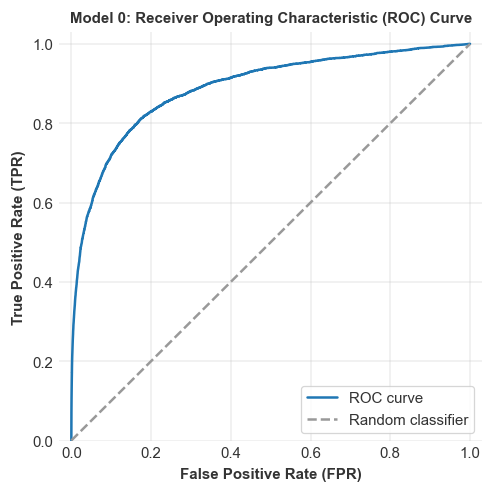

In [13]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

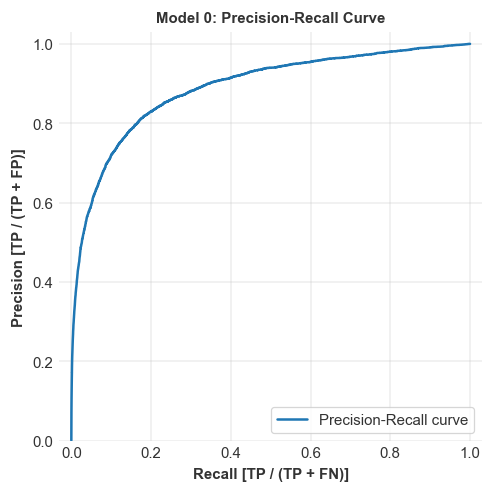

In [14]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

#### Feature importance


In [15]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
24,ab_nicu,105852.628338
50,mage_c,70393.577285
38,ca_disor,56438.020905
30,ca_cchd,33371.396974
46,dbwt,29589.740411
6,gestrec10,16661.463954
22,ab_aven1,14928.492785
48,wtgain,11716.959352
49,bmi,10566.984246
51,fagecomb,9535.621787


### Evaluation subset for permutation importances and SHAP analysis


In [16]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

In [17]:
model_wrapped = ml_utils.LGBMEstimator(gbm)

In [18]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
38,ca_disor,1.425493e-02,0.000379
30,ca_cchd,1.345560e-02,0.000427
50,mage_c,1.320068e-02,0.000501
24,ab_nicu,6.159493e-03,0.000561
46,dbwt,2.730123e-03,0.000358
6,gestrec10,2.189011e-03,0.000321
19,dmeth_rec,1.385505e-03,0.000346
48,wtgain,1.046148e-03,0.000309
40,mracehisp,6.433097e-04,0.000195
22,ab_aven1,5.599280e-04,0.000336


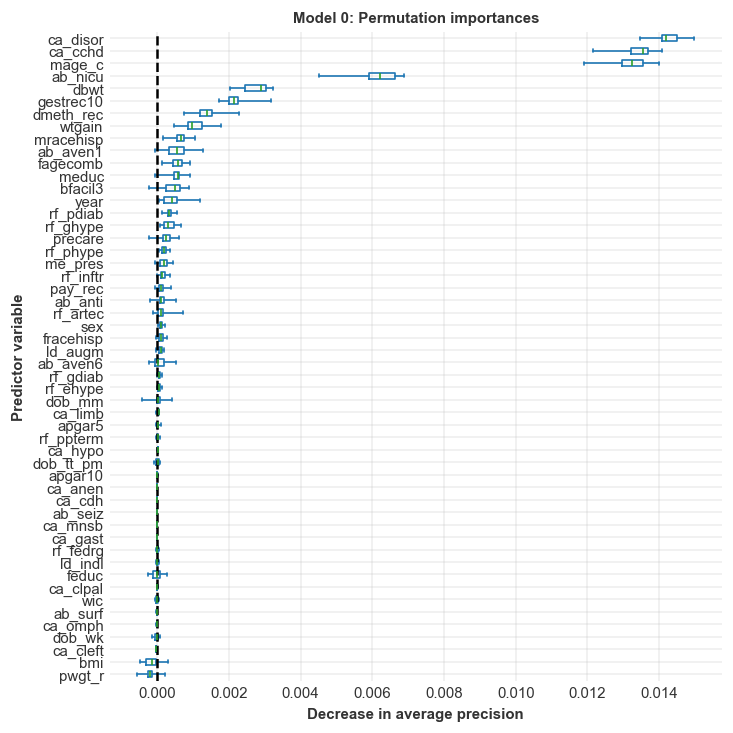

In [19]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

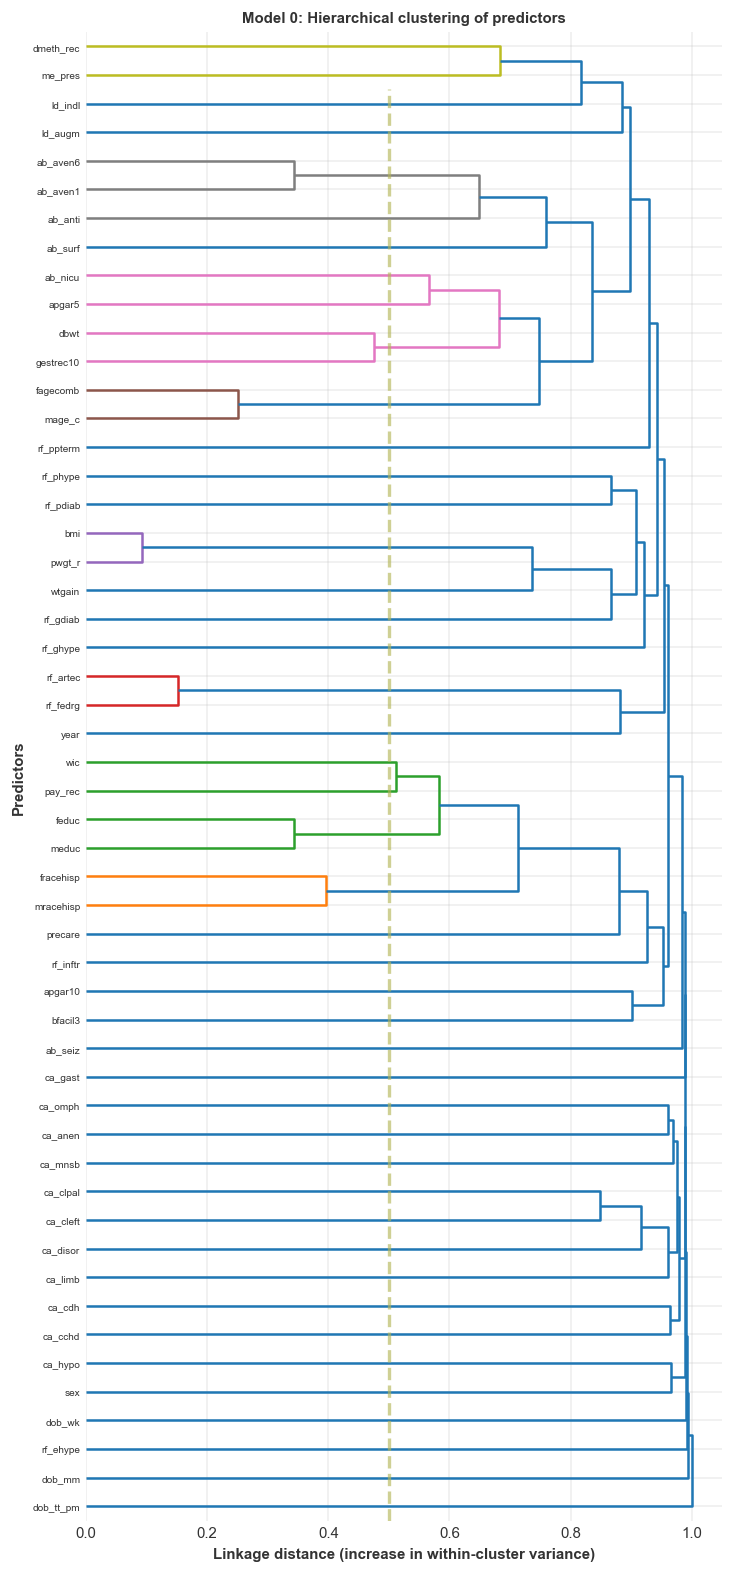

In [20]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

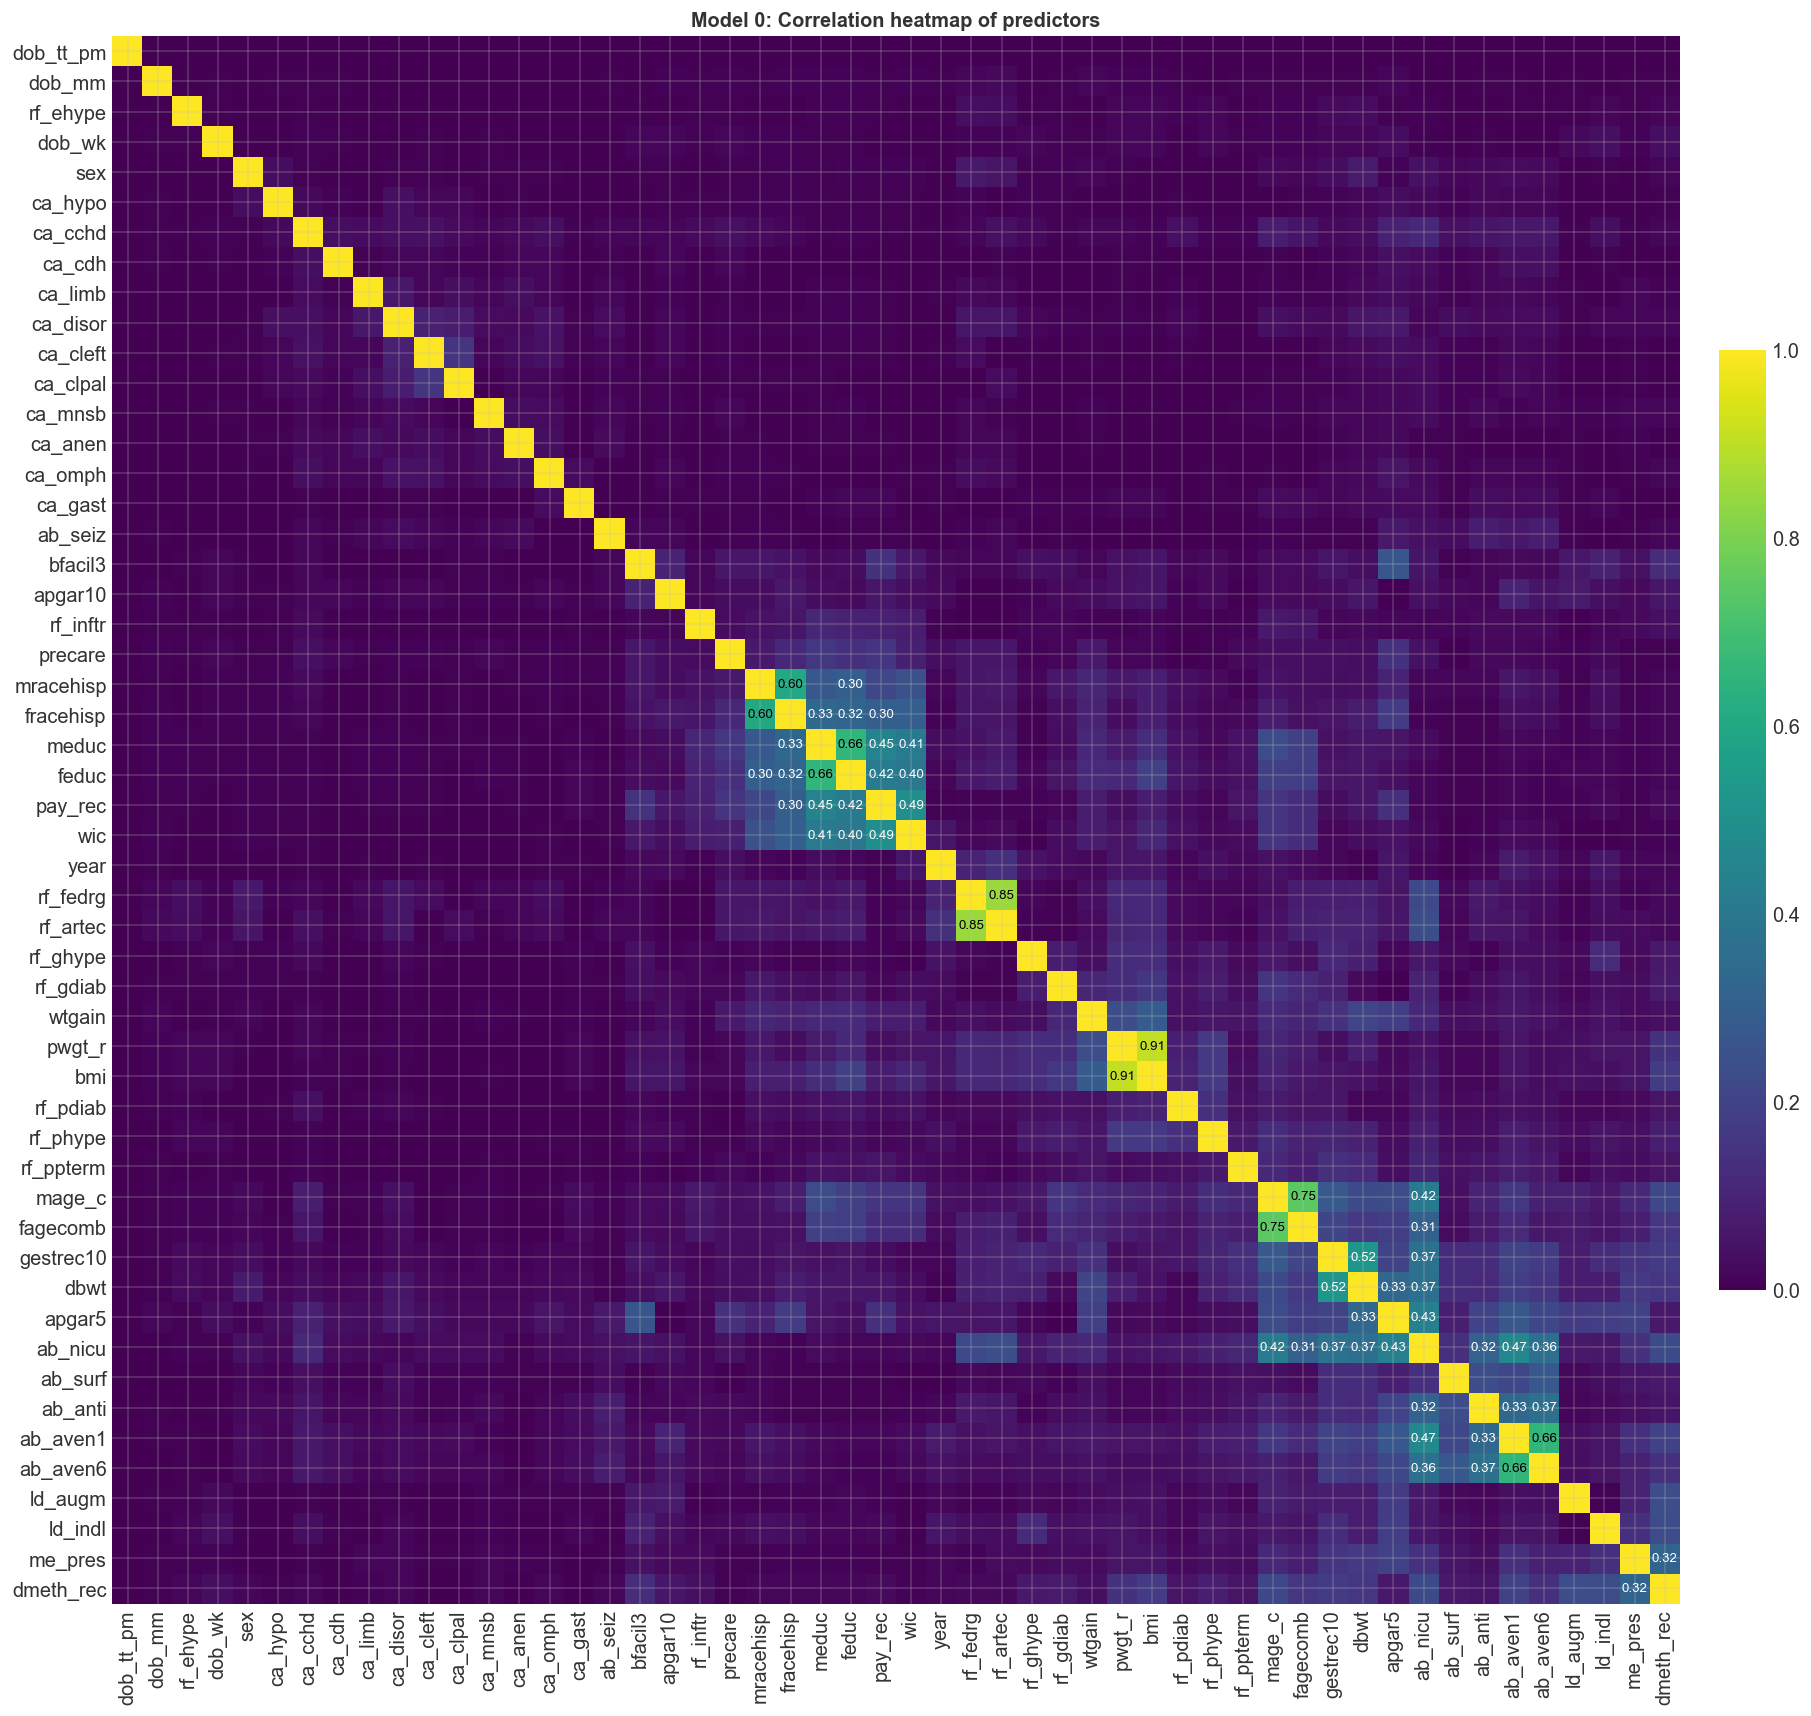

In [21]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [22]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
24,ab_nicu,0.882565
50,mage_c,0.685695
46,dbwt,0.302420
6,gestrec10,0.273520
22,ab_aven1,0.211168
40,mracehisp,0.099240
38,ca_disor,0.084870
48,wtgain,0.082111
30,ca_cchd,0.081348
39,meduc,0.050501


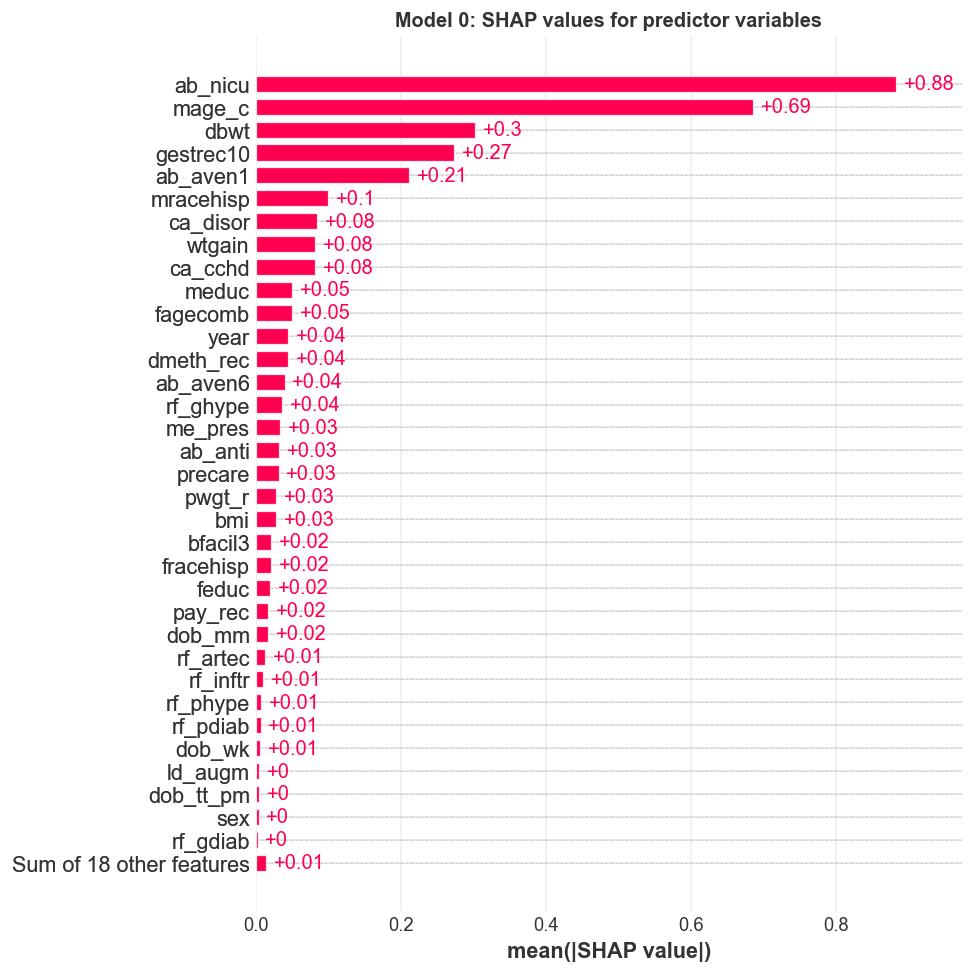

<Figure size 492x348 with 0 Axes>

In [23]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

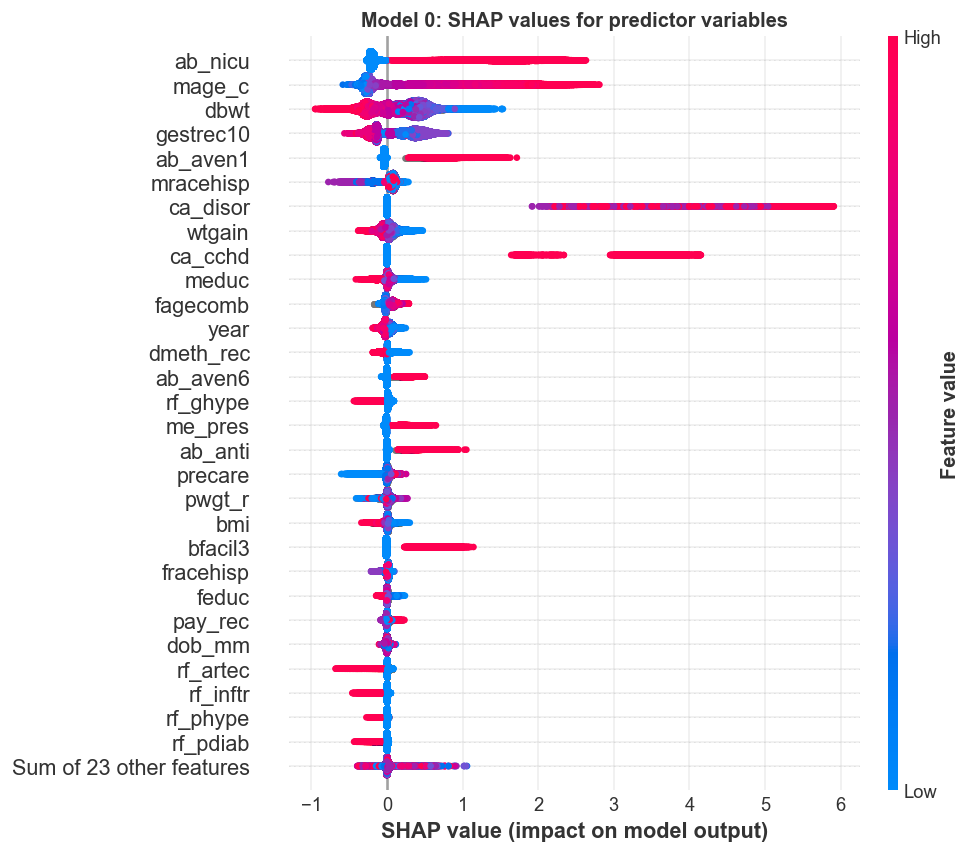

<Figure size 492x348 with 0 Axes>

In [24]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

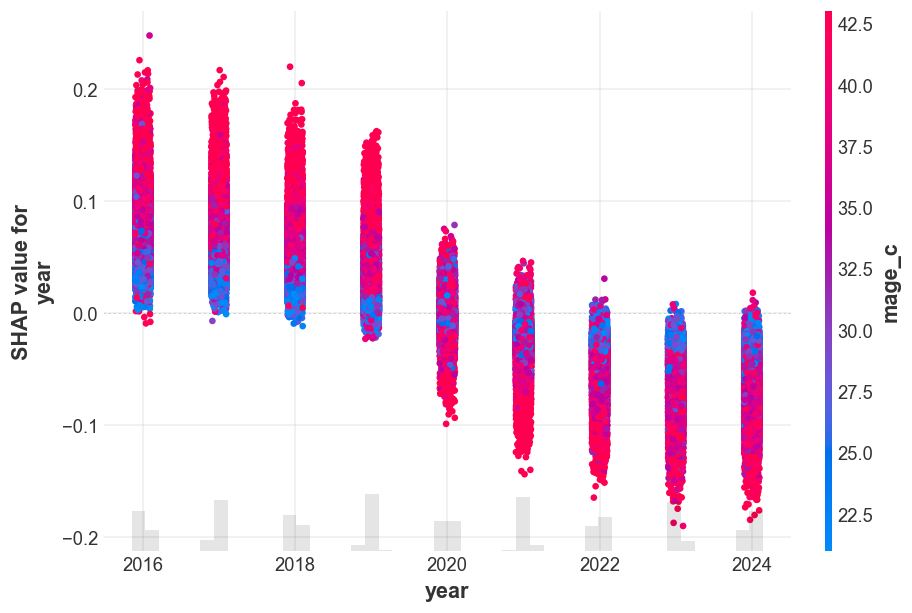

<Figure size 492x348 with 0 Axes>

In [25]:
ax = shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
# ax.set_title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 1


In [26]:
features_to_remove_0 = [
    "ld_augm",
    "rf_ehype",
    "sex",
    "pwgt_r",
]

X_train = X_train.drop(columns=features_to_remove_0)
X_valid = X_valid.drop(columns=features_to_remove_0)
X_cal = X_cal.drop(columns=features_to_remove_0)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_0]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 1
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_0)} predictors)"
)

print(f"Features removed: {features_to_remove_0}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

Features removed: ['ld_augm', 'rf_ehype', 'sex', 'pwgt_r']
Features remaining: ['dob_mm', 'dob_wk', 'dob_tt_pm', 'bfacil3', 'precare', 'gestrec10', 'rf_pdiab', 'rf_gdiab', 'rf_phype', 'rf_ghype', 'rf_ppterm', 'rf_inftr', 'rf_fedrg', 'rf_artec', 'ld_indl', 'me_pres', 'dmeth_rec', 'apgar5', 'apgar10', 'ab_aven1', 'ab_aven6', 'ab_nicu', 'ab_surf', 'ab_anti', 'ab_seiz', 'ca_anen', 'ca_mnsb', 'ca_cchd', 'ca_cdh', 'ca_omph', 'ca_gast', 'ca_limb', 'ca_cleft', 'ca_clpal', 'ca_hypo', 'ca_disor', 'meduc', 'mracehisp', 'feduc', 'fracehisp', 'pay_rec', 'wic', 'year', 'dbwt', 'wtgain', 'bmi', 'mage_c', 'fagecomb']
Number of features in Model 1 (after removing 4 predictors): 48


In [27]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

[LightGBM] [Info] Number of positive: 8904, number of negative: 16754948
[LightGBM] [Info] Total Bins 897
[LightGBM] [Info] Number of data points in the train set: 16763852, number of used features: 48
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000531 -> initscore=-7.539948
[LightGBM] [Info] Start training from score -7.539948
Training until validation scores don't improve for 20 rounds
[10]	train's average_precision: 0.0266908	train's binary_logloss: 0.00388922	valid's average_precision: 0.0269387	valid's binary_logloss: 0.00390304
[20]	train's average_precision: 0.0311316	train's binary_logloss: 0.0037298	valid's average_precision: 0.0288841	valid's binary_logloss: 0.00376672
[30]	train's average_precision: 0.0346361	train's binary_logloss: 0.00363994	valid's average_precision: 0.0301515	valid's binary_logloss: 0.0036984
[40]	train's average_precision: 0.0374314	train's binary_logloss: 0.0035771	valid's average_precision: 0.0307586	valid's binary_logloss: 0.00365492
[50]	train

In [28]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [29]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

,metric,value
0,Validation AUC,0.890298
1,Validation AP,0.031911
2,Validation log loss,0.003596
3,Precision at 10000,0.067100
4,Recall at 10000,0.150719
5,Precision (threshold=0.01),0.030319
6,Recall (threshold=0.01),0.275606


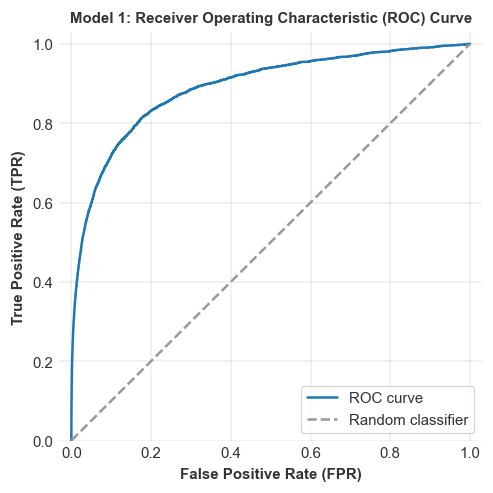

In [30]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

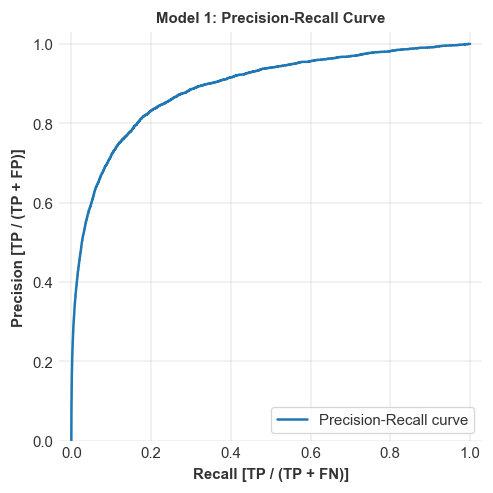

In [31]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [32]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

,feature,importance_gain
21,ab_nicu,101624.351467
35,ca_disor,71383.663334
46,mage_c,66907.802136
43,dbwt,37696.474572
5,gestrec10,18140.400703
45,bmi,16516.136685
44,wtgain,16133.941220
47,fagecomb,14717.407987
20,ab_aven6,13734.313162
27,ca_cchd,11265.527892


In [33]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [34]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

,feature,importance_mean,importance_std
35,ca_disor,0.012710,0.000317
46,mage_c,0.012199,0.000470
27,ca_cchd,0.010407,0.000506
21,ab_nicu,0.007882,0.000357
20,ab_aven6,0.003014,0.000314
43,dbwt,0.002460,0.000411
5,gestrec10,0.002252,0.000316
16,dmeth_rec,0.001667,0.000304
44,wtgain,0.000858,0.000297
37,mracehisp,0.000613,0.000130


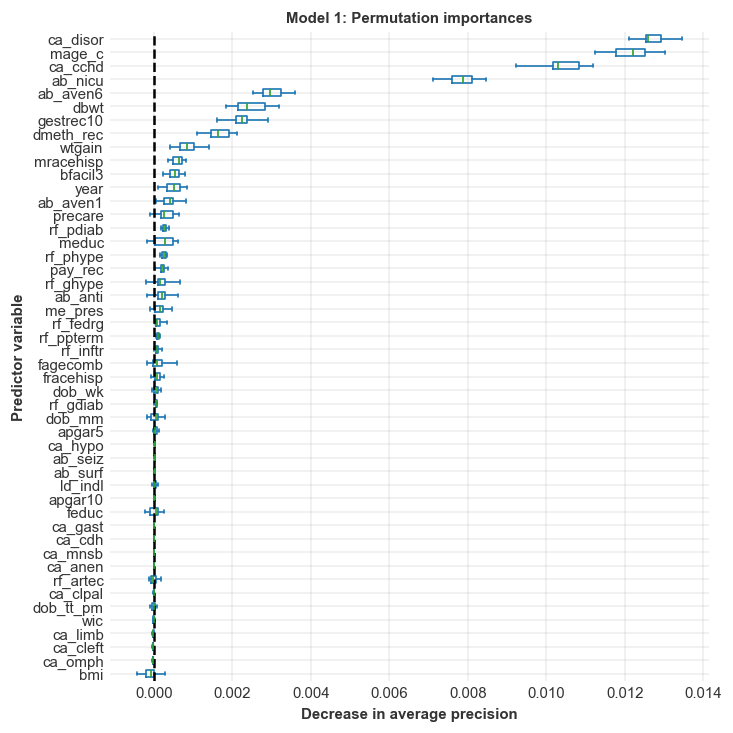

In [35]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

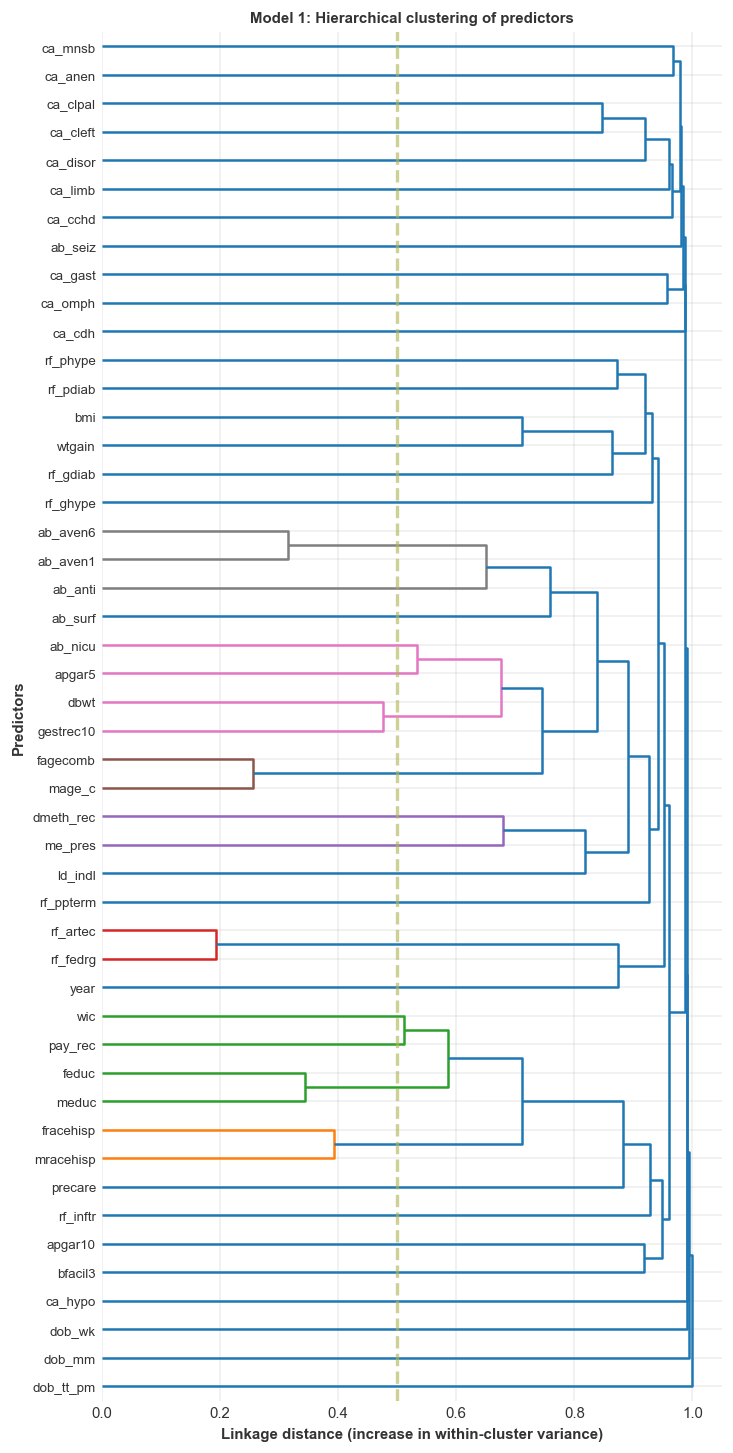

In [36]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

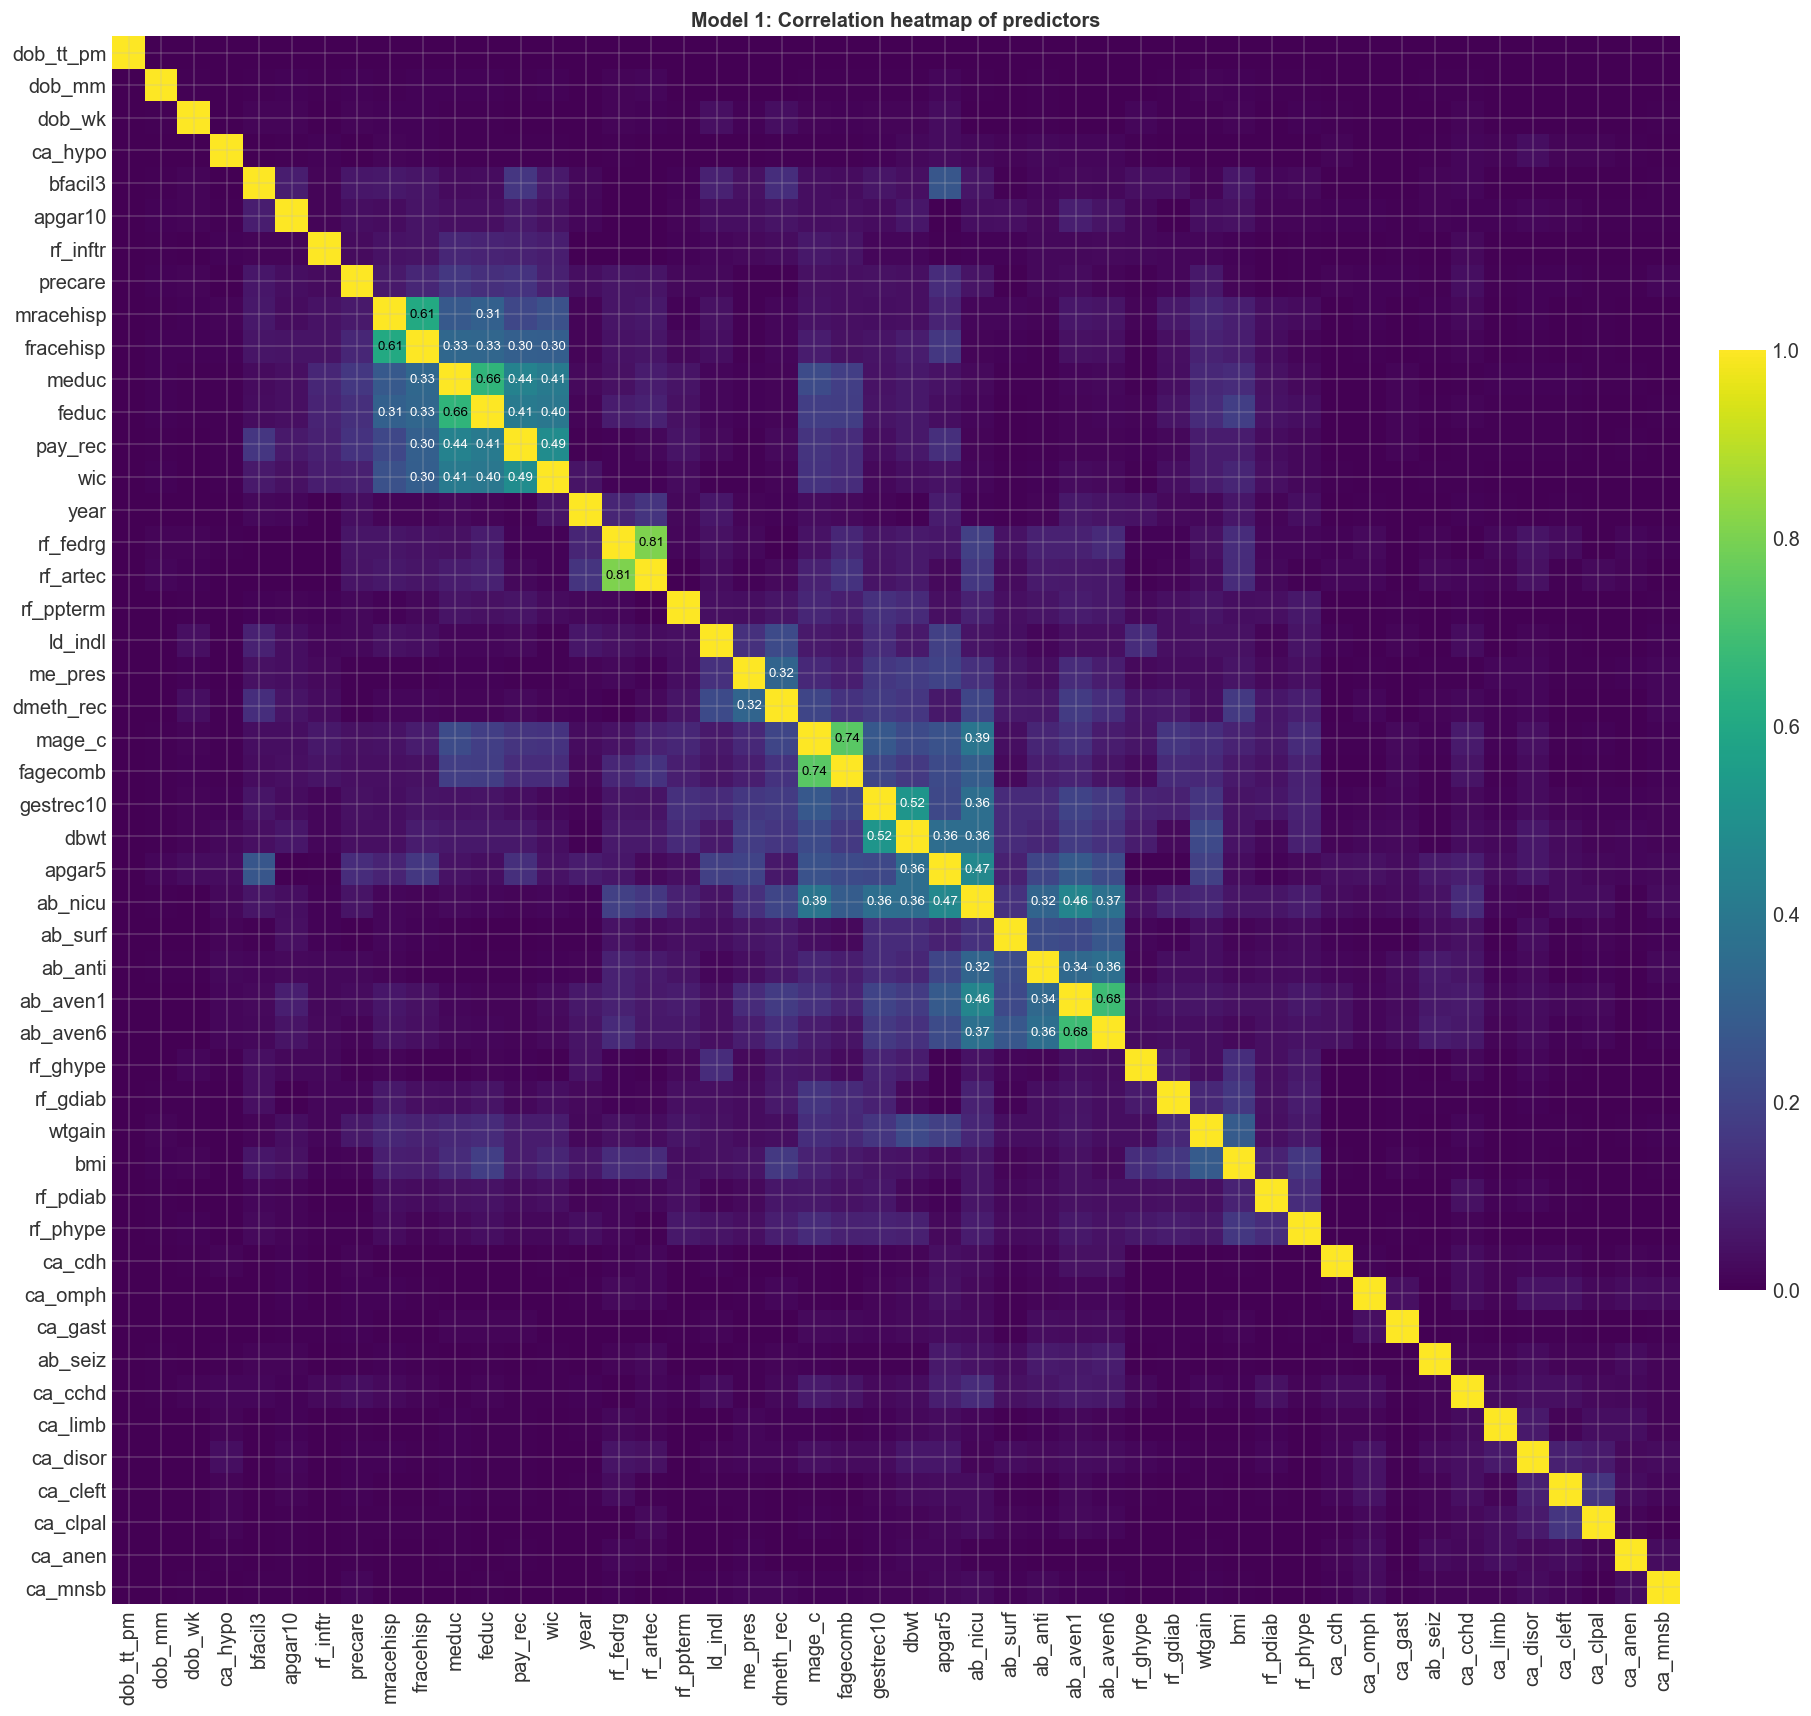

In [37]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [38]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 0 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 1 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clustering.py:170: UserWarning: No/low signal found from feature 2 (this is typically caused by constant or near-constant features)! Cluster distances can't be computed for it (so setting all redundancy distances to 1).
  warnings.warn(
v:\miniforge3\envs\data-stats-models-ml\Lib\site-packages\shap\utils\_clusterin

,feature,mean_abs_shap
21,ab_nicu,0.872490
46,mage_c,0.713154
43,dbwt,0.334563
5,gestrec10,0.303262
19,ab_aven1,0.178687
37,mracehisp,0.118669
44,wtgain,0.102695
35,ca_disor,0.085853
27,ca_cchd,0.074576
20,ab_aven6,0.068295


In [39]:
shap_importance["feature"].tolist()

['ab_nicu',
 'mage_c',
 'dbwt',
 'gestrec10',
 'ab_aven1',
 'mracehisp',
 'wtgain',
 'ca_disor',
 'ca_cchd',
 'ab_aven6',
 'meduc',
 'fagecomb',
 'year',
 'dmeth_rec',
 'rf_ghype',
 'precare',
 'ab_anti',
 'me_pres',
 'bmi',
 'dob_mm',
 'feduc',
 'fracehisp',
 'bfacil3',
 'pay_rec',
 'dob_wk',
 'rf_phype',
 'rf_fedrg',
 'rf_pdiab',
 'rf_inftr',
 'apgar5',
 'rf_artec',
 'dob_tt_pm',
 'ld_indl',
 'rf_ppterm',
 'rf_gdiab',
 'ab_surf',
 'wic',
 'ca_cleft',
 'apgar10',
 'ca_clpal',
 'ca_limb',
 'ca_hypo',
 'ca_omph',
 'ab_seiz',
 'ca_gast',
 'ca_cdh',
 'ca_anen',
 'ca_mnsb']

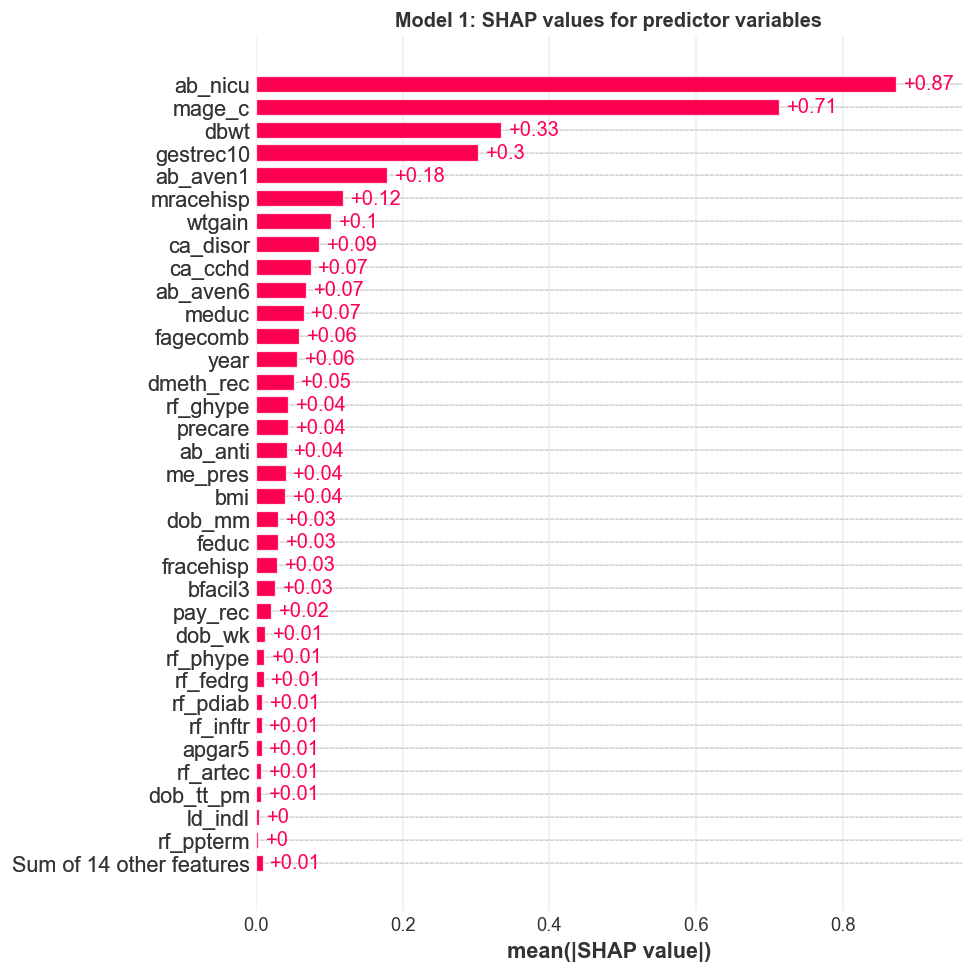

<Figure size 492x348 with 0 Axes>

In [40]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

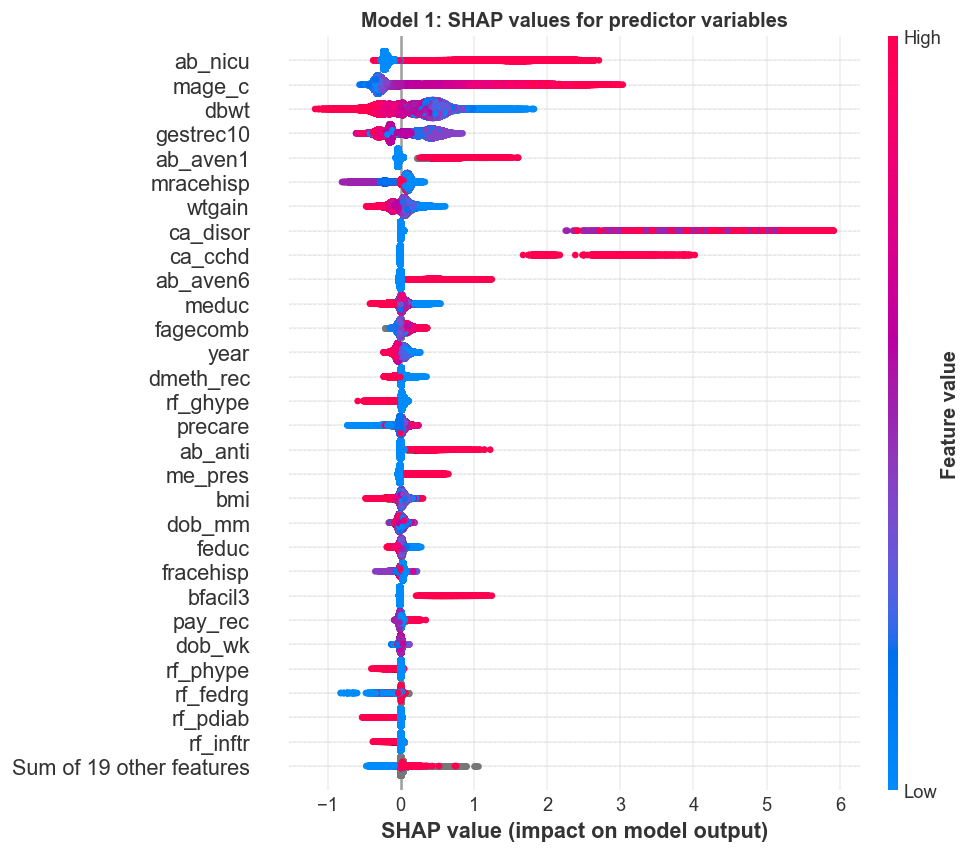

<Figure size 492x348 with 0 Axes>

In [41]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

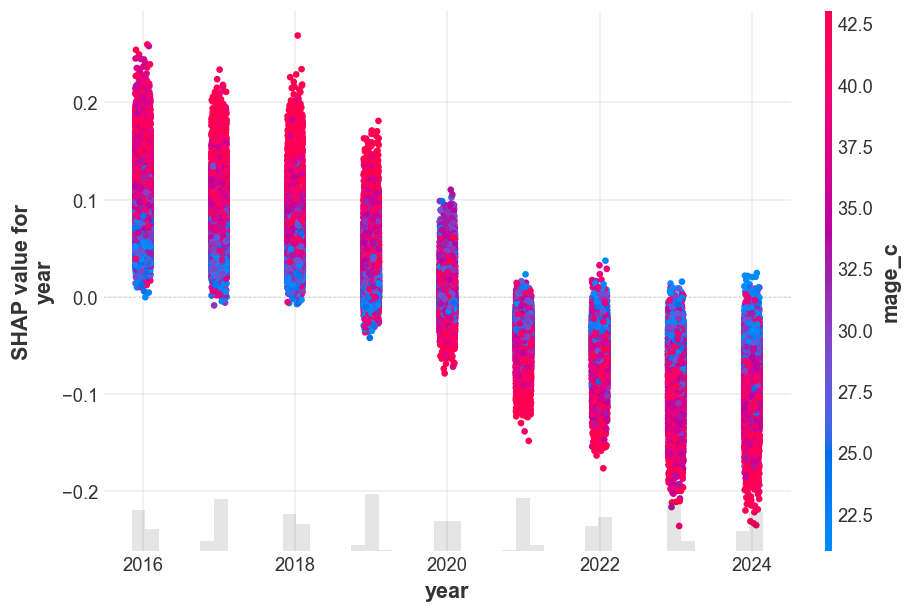

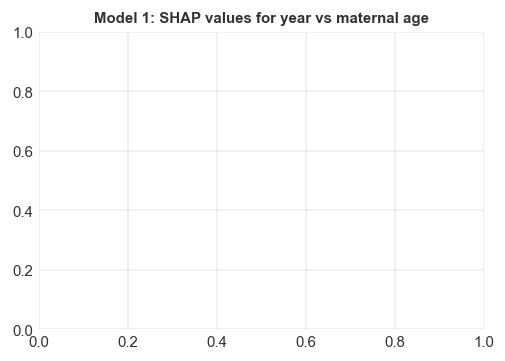

In [42]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Model 2


In [ ]:
features_to_remove_1 = [
    "rf_ppterm",
]

X_train = X_train.drop(columns=features_to_remove_1)
X_valid = X_valid.drop(columns=features_to_remove_1)
X_cal = X_cal.drop(columns=features_to_remove_1)

features = X_train.columns.to_list()
categorical = [col for col in categorical if col not in features_to_remove_1]

train_data = lgb.Dataset(
    X_train, label=y_train, categorical_feature=categorical, free_raw_data=False
)

valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical,
    reference=train_data,
    free_raw_data=False,
)

model_idx = 2
model_name = (
    f"Model {model_idx} (after removing {len(features_to_remove_1)} predictors)"
)

print(f"Features removed: {features_to_remove_1}")
print(f"Features remaining: {features}")
print(f"Number of features in {model_name}: {X_train.shape[1]}")

In [ ]:
gbm = lgb.train(
    params,
    train_data,
    num_boost_round=NUM_BOOST_ROUND,
    valid_sets=[train_data, valid_data],
    valid_names=["train", "valid"],
    callbacks=[
        early_stopping(stopping_rounds=EARLY_STOPPING_ROUNDS),
        log_evaluation(period=10),
    ],
)

best_iter = gbm.best_iteration
gbm.save_model(
    f"{OUTPUT_DIR}/model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
p_valid = gbm.predict(X_valid, num_iteration=best_iter)

In [ ]:
metrics_df, p_valid_fpr, p_valid_tpr, p_valid_thresholds = ml_utils.get_metrics(
    y_valid, p_valid, K=10000, thr=0.01
)

metrics_df.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_validation_metrics.csv",
    index=False,
)

metrics_df

In [ ]:
plot_utils.plot_roc_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_roc_curve",
)

In [ ]:
plot_utils.plot_precision_recall_curve(
    p_valid_fpr,
    p_valid_tpr,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_precision_recall_curve",
)

In [ ]:
importance_gain = gbm.feature_importance(importance_type="gain")

df_imp_gain = pd.DataFrame(
    {"feature": features, "importance_gain": importance_gain}
).sort_values("importance_gain", ascending=False)

df_imp_gain.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_feature_importance_gain.csv",
    index=False,
)
df_imp_gain

In [ ]:
X_eval, y_eval = ml_utils.build_explain_set(gbm, X_valid, y_valid, categorical)

model_wrapped = ml_utils.LGBMEstimator(gbm)

In [ ]:
result = permutation_importance(
    model_wrapped,
    X_eval,
    y_eval,
    scoring=ml_utils.ap_scorer,
    n_repeats=20,
    n_jobs=8,
    random_state=RANDOM_SEED,
)

perm_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "importance_mean": result.importances_mean,
        "importance_std": result.importances_std,
    }
).sort_values("importance_mean", ascending=False)

perm_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_permutation_importance.csv",
    index=False,
)
perm_importance

In [ ]:
plot_utils.plot_permutation_importances(
    result,
    X_eval,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_permutation_importances",
)

In [ ]:
distance, corr = stats_utils.distance_corr_dissimilarity(X_eval)
condensed = squareform(distance, checks=True)
dist_linkage = hierarchy.linkage(condensed, method="average")
dendro_labels = X_eval.columns.to_list()
dendro = plot_utils.plot_dendrogram(
    dist_linkage,
    dendro_labels,
    model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_dendrogram",
)

In [ ]:
plot_utils.plot_correlation_heatmap(
    corr,
    dendro,
    label_threshold=0.3,
    model_idx=model_idx,
    save=SAVE_PLOTS,
    output_dir=OUTPUT_DIR,
    file_name=f"model_{model_idx}_correlation_heatmap",
)

In [ ]:
explainer = shap.TreeExplainer(
    gbm, feature_perturbation="tree_path_dependent", model_output="raw"
)

explanation = explainer(X_eval)

clustering = shap.utils.hclust(
    X_eval, y_eval, linkage="average", random_state=RANDOM_SEED
)

shap_values = explanation.values

shap_importance = pd.DataFrame(
    {
        "feature": X_eval.columns,
        "mean_abs_shap": np.mean(np.abs(shap_values), axis=0),
    }
).sort_values("mean_abs_shap", ascending=False)

shap_importance.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_shap_importance.csv",
    index=False,
)
shap_importance

In [ ]:
shap_importance["feature"].tolist()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure(figsize=(8, 8))
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.bar(explanation, max_display=35, ax=ax)
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.png", dpi=300, bbox_inches="tight"
        )
        plt.savefig(f"{OUTPUT_DIR}/model_{model_idx}_shap_bar.svg", bbox_inches="tight")
    plt.show()

In [ ]:
with plt.rc_context({"axes.titlesize": 12}):
    plot = plt.figure()
    ax = plot.subplots()
    ax.set_title(f"Model {model_idx}: SHAP values for predictor variables")
    shap.plots.beeswarm(explanation, max_display=30, plot_size=(8, 7))
    if SAVE_PLOTS:
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.png",
            dpi=300,
            bbox_inches="tight",
        )
        plt.savefig(
            f"{OUTPUT_DIR}/model_{model_idx}_shap_beeswarm.svg",
            bbox_inches="tight",
        )
    plt.show()

In [ ]:
shap.plots.scatter(explanation[:, "year"], color=explanation[:, "mage_c"])
plt.title(f"Model {model_idx}: SHAP values for year vs maternal age")
if SAVE_PLOTS:
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.png",
        dpi=300,
        bbox_inches="tight",
    )
    plt.savefig(
        f"{OUTPUT_DIR}/model_{model_idx}_shap_year_vs_maternal_age.svg",
        bbox_inches="tight",
    )
plt.show()

## Calibration


In [ ]:
p_cal_raw = gbm.predict(X_cal, num_iteration=gbm.best_iteration, raw_score=True)

In [ ]:
calibrator = LogisticRegression(solver="lbfgs", max_iter=1000)
calibrator.fit(p_cal_raw.reshape(-1, 1), y_cal)

In [ ]:
def predict_proba_calibrated(gbm, calibrator, X_new, num_iteration=None):
    p_raw = gbm.predict(X_new, num_iteration=num_iteration, raw_score=True)
    return calibrator.predict_proba(p_raw.reshape(-1, 1))[:, 1]

## Prediction


In [ ]:
p_valid_cal = predict_proba_calibrated(
    gbm, calibrator, X_valid, num_iteration=gbm.best_iteration
)

p_valid_raw = gbm.predict(X_valid, num_iteration=gbm.best_iteration, raw_score=False)

print("best_iteration:", gbm.best_iteration)
print("mean raw prob:", float(p_valid_raw.mean()))
print("mean cal prob:", float(p_valid_cal.mean()))


print("Raw logloss:", log_loss(y_valid, p_valid_raw, labels=[0, 1]))
print("Cal logloss:", log_loss(y_valid, p_valid_cal, labels=[0, 1]))
print("Raw brier:  ", brier_score_loss(y_valid, p_valid_raw))
print("Cal brier:  ", brier_score_loss(y_valid, p_valid_cal))

In [ ]:
def tail_calibration_table(y, p, fracs=(1e-2, 1e-3, 1e-4, 1e-5)):
    """
    Compare predicted vs observed event rates in the top fracs of scores.

    Parameters
    ----------
    y : array-like (0/1)
    p : array-like (probabilities)
    fracs : iterable of floats
        Fractions like 1e-3 for top 0.1%.

    Returns
    -------
    DataFrame with k, predicted mean, observed rate, and counts.
    """
    y = np.asarray(y).astype(int)
    p = np.asarray(p).astype(float)

    order = np.argsort(-p)
    y_sorted = y[order]
    p_sorted = p[order]

    N = len(y)
    rows = []
    for f in fracs:
        k = max(1, int(round(N * f)))
        y_top = y_sorted[:k]
        p_top = p_sorted[:k]

        obs_rate = y_top.mean()
        pred_rate = p_top.mean()

        tp = int(y_top.sum())
        fp = int(k - tp)

        rows.append(
            {
                "top_frac": f,
                "k": k,
                "pred_rate_mean": pred_rate,
                "obs_rate": obs_rate,
                "tp": tp,
                "fp": fp,
                "pred_minus_obs": pred_rate - obs_rate,
                "ratio_pred_to_obs": (pred_rate / obs_rate) if obs_rate > 0 else np.nan,
            }
        )

    return pd.DataFrame(rows)

In [ ]:
fracs = (1e-2, 1e-3, 1e-4, 1e-5)  # 1%, 0.1%, 0.01%, 0.001%

calibration_table_raw = tail_calibration_table(y_valid, p_valid_raw, fracs=fracs)
calibration_table_cal = tail_calibration_table(y_valid, p_valid_cal, fracs=fracs)

calibration_table_raw["model"] = "raw"
calibration_table_cal["model"] = "calibrated"
calibration_table_combined = pd.concat(
    [calibration_table_raw, calibration_table_cal], ignore_index=True
)

calibration_table_combined.to_csv(
    f"{OUTPUT_DIR}/model_{model_idx}_tail_calibration_table.csv",
    index=False,
)

calibration_table_combined

In [ ]:
gbm.save_model(
    f"{OUTPUT_DIR}/final_model_{model_idx}.txt",
    num_iteration=best_iter,
)

In [ ]:
joblib.dump(calibrator, f"{OUTPUT_DIR}/final_calibrator.joblib")

meta = {
    "features": list(X_train.columns),
    "best_iteration": int(getattr(gbm, "best_iteration", 0) or 0),
    "calibration_input": "raw_score",  # or "prob"
}

joblib.dump(meta, f"{OUTPUT_DIR}/final_model_meta.joblib")

In [ ]:
X_full = df[features]
p_full_cal = predict_proba_calibrated(
    gbm, calibrator, X_full, num_iteration=gbm.best_iteration
)

In [ ]:
df["p_ds_lb_pred_01"] = p_full_cal

In [ ]:
df[["year", "p_ds_lb_pred"]].groupby("year").sum().reset_index()

In [ ]:
import duckdb

con = duckdb.connect("./data/us_births.db")

In [ ]:
con.execute(
    """
    ALTER TABLE us_births ADD COLUMN IF NOT EXISTS p_ds_lb_pred_01 DOUBLE;
    """
)
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")
con.execute(f"CREATE TABLE ds_lb_pred_01 (id BIGINT, p_ds_lb_pred DOUBLE)")

In [ ]:
con.execute(
    """
    INSERT INTO ds_lb_pred_01 (id, p_ds_lb_pred)
    SELECT id, p_ds_lb_pred_01
    FROM df
    """
)

In [ ]:
con.execute(
    """
    UPDATE us_births b
    SET p_ds_lb_pred_01 = p.p_ds_lb_pred
    FROM ds_lb_pred_01 p
    WHERE b.id = p.id;
    """
)

In [ ]:
con.execute("DROP TABLE IF EXISTS ds_lb_pred_01")

In [ ]:
con.close()